# Optimiser la gestion des données d'une boutique 

L'objectif de ce projet est de faire cohabiter les différents jeux de données dont nous disposons afin de réaliser une analyse sur les CA et identifier les potentiels outliers. Pour cela, nous allons notamment devoir :
- Classifier différents types de données
- Gérer les erreurs et les incohérences présentes sur des données stockées
- Réaliser une analyse univariée pour interpréter des données

## Importation des librairies et datas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
base_dir = r"C:\Users\ynore\projet_5"
df_erp = pd.read_excel(base_dir + "\erp.xlsx")
df_web = pd.read_excel(base_dir + "\web.xlsx")
df_liaison = pd.read_excel(base_dir + "\liaison.xlsx")

## 1. Analyse exploratoire des données

### 1.1 DF ERP

In [3]:
df_erp.sample(10)

,product_id,onsale_web,price,stock_quantity,stock_status
80,4151,1,13.7,0,outofstock
738,6592,1,24.4,70,instock
414,4909,1,25.9,27,instock
180,4274,1,12.9,0,outofstock
721,6280,1,10.4,0,outofstock
281,4647,1,28.5,48,instock
108,4181,1,11.9,137,instock
418,4913,1,28.0,16,instock
285,4651,1,49.0,21,instock
506,5445,1,16.3,11,instock


In [4]:
df_erp.shape

(825, 5)

La méthode shape de Pandas renvoie un tuple représentant les dimensions, c'est-à-dire les lignes et les colonnes, du DataFrame

In [5]:
df_erp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


In [6]:
df_erp.describe()

,product_id,onsale_web,price,stock_quantity
count,825.000000,825.000000,825.000000,825.000000
mean,5162.597576,0.869091,32.415636,26.496970
std,902.644635,0.337506,26.795849,45.892422
min,3847.000000,0.000000,5.200000,0.000000
25%,4348.000000,1.000000,14.600000,1.000000
50%,4907.000000,1.000000,24.400000,11.000000
75%,5805.000000,1.000000,42.000000,34.000000
max,7338.000000,1.000000,225.000000,578.000000


Il semblerait que : 
- les variables price & stock quantity comportent des outliers
- Les écarts types sont élevés, ce qui indique que les données sont dispersées

In [7]:
# Vérification de la présence de NaN

df_erp.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

In [8]:
# Recherche de doublons dans la colonne ID

df_erp.loc[df_erp['product_id'].duplicated(keep=False),:]

,product_id,onsale_web,price,stock_quantity,stock_status


Pas de doublons à signaler au niveau de l'id des produits

<AxesSubplot:xlabel='stock_quantity'>

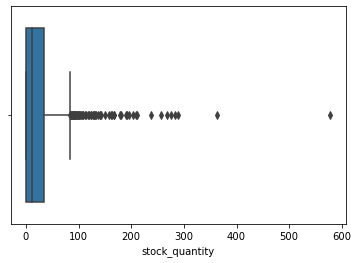

In [9]:
# Recherche d'outliers

sns.boxplot(df_erp['stock_quantity'])

Il existe au moins un outliers dans la variable stock quantity, cela dit, il s'agit probablement d'une valeur atypique, mais juste, plutôt que d'une erreur

In [10]:
df_erp.loc[df_erp['stock_quantity'] > 300]

,product_id,onsale_web,price,stock_quantity,stock_status
130,4208,1,7.6,578,instock
707,6207,1,25.2,363,instock


<AxesSubplot:xlabel='price'>

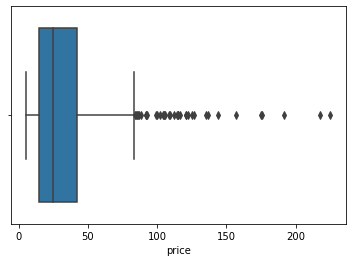

In [11]:
sns.boxplot(df_erp['price'])

Idem concernant la répartition des prix, il semblerait qu'il existe plusieurs valeurs atypiques. Nous y reviendrons plus loin.

In [12]:
# vérification que le statut du stock correspond à sa disponibilité : 
# càd qu'un produit indiqué comme out of stock ait bien une quantité = 0 
# et qu'un produit indiqué comme en stock ait bien une quantité < 0

In [13]:
df_erp.loc[((df_erp['stock_quantity'] == 0) & (df_erp['stock_status'] == "instock"))]

,product_id,onsale_web,price,stock_quantity,stock_status
443,4954,1,25.0,0,instock


Il existe bien une erreur dans le df : un produit est indiqué comme étant en stock alors que sa quantité est = 0, nous allons donc modifier le status du stock

In [14]:
df_erp.loc[443,"stock_status"] = "outofstock"

In [15]:
df_erp.loc[((df_erp['stock_quantity'] > 0) & (df_erp['stock_status'] == "outofstock"))]

,product_id,onsale_web,price,stock_quantity,stock_status


Pas d'erreur au niveau des produits indiqués comme étant out of stock

### 1.2 DF WEB

In [17]:
# Sélection d'un échantillon au hasard

df_web.sample(10)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
137,15829,0,0,0,0.0,15.0,taxable,NaN,2.0,2018-02-16 11:06:30,...,xavier-frissant-touraine-roses-du-clos-2018,2020-08-26 15:55:03,2020-08-26 13:55:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
252,15875,0,0,0,0.0,11.0,taxable,NaN,2.0,2018-04-13 15:41:12,...,gilbert-picq-chablis-en-vaudecorse-2017,2020-08-27 16:05:03,2020-08-27 14:05:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
107,15747,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-15 09:31:31,...,borie-la-vitarele-saint-chinian-les-schistes-2017,2020-08-14 18:45:02,2020-08-14 16:45:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
375,14506,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-04-19 14:56:05,...,domaine-peyre-rose-clos-des-cistes-2008,2020-07-16 09:30:05,2020-07-16 07:30:05,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,11602,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-17 10:52:41,...,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-23 15:35:02,2020-06-23 13:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
433,16586,0,0,0,0.0,26.0,taxable,NaN,2.0,2018-06-02 09:35:14,...,chateau-turcaud-entre-deux-mers-2019,2020-08-27 10:10:25,2020-08-27 08:10:25,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
545,12366,0,0,0,0.0,0.0,taxable,NaN,2.0,2019-01-29 15:23:12,...,pares-balta-penedes-hisenda-miret-2013,2020-07-10 15:55:02,2020-07-10 13:55:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
520,13957,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-11-26 10:16:51,...,thierry-germain-saumur-champigny-franc-de-pied...,2019-04-24 20:44:49,2019-04-24 18:44:49,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
58,16505,0,0,0,0.0,12.0,taxable,NaN,2.0,2018-02-13 10:19:23,...,emile-boeckel-riesling-gc-wiebelsberg-2016,2020-08-20 09:30:18,2020-08-20 07:30:18,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [18]:
df_web.shape

(1513, 28)

In [19]:
df_web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

D'entrée de jeu, la fonction .info() nous permet de constater que :
- Plusieurs colonnes ne contiennent pas de valeurs
- Il manquera des sku (NaN)

Intéressons nous à la variable des sku :

In [20]:
df_web[df_web.sku.isna()]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
178,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Regardons si ces produits n'ayant pas d'identifiants ont été vendu. Réponse: aucun
sku_null = df_web.loc[df_web['sku'].isnull(),:]
sku_null.loc[sku_null.total_sales>0]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count


Il sembleraît qu'il s'agisse de doublons à supprimer, mais vérifions quand même juste pour en être tout à fait sûr :

In [22]:
df_web[df_web.duplicated()]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3 lignes contiennent des informations uniques, essayons de les localiser :

In [23]:
duplicate = df_web.loc[df_web['sku'].isna()]
duplicate = duplicate.drop_duplicates(keep='last')
duplicate

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,...,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,...,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
796,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Il n'y a pas eu de ventes concernant ces produits. Nous pouvons donc considérer qu'il s'agit simplement d'une erreur et les supprimer. Si des ventes avaient eu lieu, cela aurait été plus problématique dans le sens ou nous ne disposons pas du sku et il aurait donc fallu le retrouver afin de pouvoir identifier le produit. 

In [24]:
df_web.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count
count,1513.0,1513.0,1513.0,1430.0,1430.000000,0.0,1430.000000,0.0,0.0,0.0,1430.0,1430.0,1430.0
mean,0.0,0.0,0.0,0.0,4.006993,NaN,1.998601,NaN,NaN,NaN,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,8.510559,NaN,0.037385,NaN,NaN,NaN,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN,NaN,NaN,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,4.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,96.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0


On constate que 50% des ventes sont de 1 quantité

In [25]:
# Pour compter les valeurs uniques dans chaque colonne, 
# ce qui nous donnera des indications sur celles dont nous pouvons nous séparer et sur de potentiels doublons

df_web.nunique()

sku                       714
virtual                     1
downloadable                1
rating_count                1
average_rating              1
total_sales                41
tax_status                  1
tax_class                   0
post_author                 2
post_date                 716
post_date_gmt             716
post_content                0
post_title                713
post_excerpt              679
post_status                 1
comment_status              1
ping_status                 1
post_password               0
post_name                 716
post_modified             589
post_modified_gmt         589
post_content_filtered       0
post_parent                 1
guid                     1430
menu_order                  1
post_type                   2
post_mime_type              1
comment_count               1
dtype: int64

La fonction .describe() nous avait indiqué qu'il y avait 1428 valeurs dans la colonne SKU, ici .nunique() nous informe qu'il y a 714 valeurs uniques dans cette même colonne. On peut donc déjà supposer qu'il y a des doublons. Il nous faudra donc trouver une clef permettant d'éliminer toutes les lignes en double

In [26]:
df_web['sku'].value_counts()

bon-cadeau-25-euros    2
14828                  2
14679                  2
15526                  2
16305                  2
                      ..
15145                  2
15801                  2
15452                  2
15038                  2
16230                  2
Name: sku, Length: 714, dtype: int64

In [27]:
df_web['sku'].value_counts().value_counts()

2    714
Name: sku, dtype: int64

Ces deux précédentes lignes montrent que les sku sont chacun en double.

Surpprimons les colonnes pour lesquelles il n'y qu'une ou 0 valeur pour plus de clarté :

In [28]:
df_web = df_web.drop(columns = [
    'virtual', 'downloadable', 'rating_count', 'average_rating',
    'tax_class', 'post_content', 'post_status', 'comment_status', 'ping_status', 'post_password',
    'post_content_filtered', 'post_parent', 'menu_order',
    'post_mime_type', 'comment_count']) 

Jettons aussi un coup d'oeil aux colonnes ne comptant que 2 valeurs : "post_author", "post_type"

In [29]:
df_web["post_author"].value_counts()

2.0    1428
1.0       2
Name: post_author, dtype: int64

Cette variable ne nous donne pas d'information particulière

In [30]:
df_web["post_type"].value_counts()

product       716
attachment    714
Name: post_type, dtype: int64

En revanche, celle-ci semble être plus pertinente, le nombre de valeurs uniques est proche du nombre de sku unique, il serait peut-être intéressant de prendre quelques lignes au hasard et de les comparer :

In [31]:
df_web.loc[df_web['sku'] == 15300]

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product
801,15300,0.0,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.bottle-neck.fr/wp-content/uploads/...,attachment


In [32]:
df_web.loc[df_web['sku'] == 15891]

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
767,15891,0.0,taxable,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
1509,15891,0.0,NaN,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,NaN,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.bottle-neck.fr/wp-content/uploads/...,attachment


In [33]:
df_web.loc[df_web['sku'] == 13435]

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
41,13435,10.0,taxable,2.0,2018-02-12 14:52:10,2018-02-12 13:52:10,Domaine des Bosquets Gigondas La Colline 2015,"<div id=""wrapper"">\n<div id=""container-wrapper...",domaine-des-bosquets-gigondas-colline-2015,2020-07-11 15:05:02,2020-07-11 13:05:02,https://www.bottle-neck.fr/?post_type=product&...,product
839,13435,10.0,NaN,2.0,2018-02-12 14:52:10,2018-02-12 13:52:10,Domaine des Bosquets Gigondas La Colline 2015,NaN,domaine-des-bosquets-gigondas-colline-2015,2020-07-11 15:05:02,2020-07-11 13:05:02,https://www.bottle-neck.fr/wp-content/uploads/...,attachment


Notre intuition a l'air d'être correcte : chaque sku semble être présent en double dans notre table. La clef sku + post_type paraît pertinente pour supprimer les doublons. 

In [34]:
# Ne gardons dans ce cas là que les sku dont la variable a pour valeur "product".

df_web = df_web.loc[df_web['post_type'] =='product']

In [35]:
# Vérifions maintenant si notre variable sku contient encore NaN

df_web[df_web["sku"].isna()]

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
470,NaN,0.0,taxable,2.0,2018-07-31 12:07:23,2018-07-31 10:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,"Fongeant 2017 explose sur un fruit brillant, p...",pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,https://www.bottle-neck.fr/?post_type=product&...,product
471,NaN,0.0,taxable,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,https://www.bottle-neck.fr/?post_type=product&...,product


In [36]:
# et supprimons les :

df_web = df_web.dropna()
df_web

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,https://www.bottle-neck.fr/?post_type=product&...,product
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,https://www.bottle-neck.fr/?post_type=product&...,product
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.bottle-neck.fr/?post_type=product&...,product
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,https://www.bottle-neck.fr/?post_type=product&...,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,16135,5.0,taxable,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,Belle robe jeune à dominante rubis soutenue. N...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product
767,15891,0.0,taxable,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
768,15887,0.0,taxable,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,"Pour cette cuvée, Jean-Paul Jamet recherche un...",jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product
797,13127-1,0.0,taxable,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,https://www.bottle-neck.fr/?post_type=product&...,product


Voilà, la table web ne contient que des tuples uniques et toutes les informations utiles à notre analyse. Nous pourrons donc la rapprocher avec les autres.

### 1.3 DF liaison

In [37]:
df_liaison

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


In [38]:
df_liaison.shape

(825, 2)

In [39]:
df_liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


Il est important de noter que tous les produits ne disposent pas d'un id_web correspondant

In [40]:
# Détection des NaN

df_liaison.isnull().sum()

product_id     0
id_web        91
dtype: int64

In [41]:
df_liaison[df_liaison.id_web.isna()].product_id

19     4055
49     4090
50     4092
119    4195
131    4209
       ... 
817    7196
818    7200
819    7201
820    7203
821    7204
Name: product_id, Length: 91, dtype: int64

Les id_web null ici sont des produits qui ne sont pas vendus en ligne

Vérifions maintenant que chaque id_web et product_id sont bien uniques :

In [42]:
# Détection des doublons pour la variable produit_id

df_liaison.loc[df_liaison['product_id'].duplicated(keep=False),:]

,product_id,id_web


In [43]:
# Détection des doublons pour la variable id_web

df_liaison.loc[df_liaison['id_web'].duplicated(keep=False),:]

,product_id,id_web
19,4055,NaN
49,4090,NaN
50,4092,NaN
119,4195,NaN
131,4209,NaN
...,...,...
817,7196,NaN
818,7200,NaN
819,7201,NaN
820,7203,NaN


In [44]:
df_liaison.nunique()

product_id    825
id_web        734
dtype: int64

Nos 734 produits disposent bien tous d'un ID unique et d'un ID web correspondant également unique. Nous pouvons désormais joindre les tables.

## 2. Rapprochement des tables pour analyse

In [45]:
# D'abord nous effectuons un .merge entre le df_liaison et le df_erp 
# J'utilise une jointure externe accompagnée du paramètre indicator  =  True afin de pouvoir identifier les valeurs pour laquelle la clef n'apapraît pas dans une des 2 tables
# Une autre solution aurait été d'utiliser une jointure à droite, mais celle-ci génère de la perte d'information

table_produit = pd.merge(df_erp, df_liaison, how = 'outer', on = ['product_id'], indicator=True)
table_produit

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
0,3847,1,24.2,0,outofstock,15298,both
1,3849,1,34.3,0,outofstock,15296,both
2,3850,1,20.8,0,outofstock,15300,both
3,4032,1,14.1,0,outofstock,19814,both
4,4039,1,46.0,0,outofstock,19815,both
...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN,both
821,7204,0,45.0,9,instock,NaN,both
822,7247,1,54.8,23,instock,13127-1,both
823,7329,0,26.5,14,instock,14680-1,both


L'utilisation de l'indicator = True permet de créer une nouvelle colonne qui nous donne des informations sur la source de chaque ligne. Cette colonne prend la valeur "left_only" pour les observations dont la clé n'apparaît que dans le DataFrame 'left', "right_only" pour les observations dont la clef n'apparaît que dans le DataFrame 'right', et "both" si la clé de l'observation se trouve dans les deux.

Une recherche des valeurs "both", nous indiquera donc si la jointure dispose de toutes les informations des 2 tables :

In [46]:
table_produit.loc[table_produit["_merge"] == "both"]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
0,3847,1,24.2,0,outofstock,15298,both
1,3849,1,34.3,0,outofstock,15296,both
2,3850,1,20.8,0,outofstock,15300,both
3,4032,1,14.1,0,outofstock,19814,both
4,4039,1,46.0,0,outofstock,19815,both
...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN,both
821,7204,0,45.0,9,instock,NaN,both
822,7247,1,54.8,23,instock,13127-1,both
823,7329,0,26.5,14,instock,14680-1,both


In [47]:
table_produit._merge.value_counts()

both          825
left_only       0
right_only      0
Name: _merge, dtype: int64

On constate que l'on dispose bien de 825 tuples pour lesquels nous disposons des informations des 2 tables. Gardons en tête qu'il faudra supprimer les NaN à un moment

In [48]:
table_produit.drop(['_merge'], axis=1, inplace=True)

Maintenant je peux effectuer la jointure entre la table obtenue et le df_web qui nous permettra de regrouper les données utiles à notre analyse dans un même et unique tableau

In [49]:
table_analyse = pd.merge(df_web,table_produit, how = 'outer', left_on = 'sku', right_on='id_web', indicator=True)
table_analyse

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,https://www.bottle-neck.fr/?post_type=product&...,product,4954,1,25.0,0,outofstock,bon-cadeau-25-euros,both
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,https://www.bottle-neck.fr/?post_type=product&...,product,3847,1,24.2,0,outofstock,15298,both
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.bottle-neck.fr/?post_type=product&...,product,3849,1,34.3,0,outofstock,15296,both
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product,3850,1,20.8,0,outofstock,15300,both
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,https://www.bottle-neck.fr/?post_type=product&...,product,4032,1,14.1,0,outofstock,19814,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5954,0,18.8,0,outofstock,15609,right_only
821,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5955,0,27.3,0,outofstock,14377,right_only
822,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5957,0,39.0,0,outofstock,13577,right_only
823,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,6100,0,12.9,0,outofstock,15529,right_only


In [50]:
table_analyse['_merge'].value_counts()

both          714
right_only    111
left_only       0
Name: _merge, dtype: int64

Si on s'intéresse aux "right_only" : 

In [51]:
right_only = table_analyse[table_analyse['_merge']=='right_only']
right_only

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
714,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,4055,0,86.1,0,outofstock,NaN,right_only
715,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,4090,0,73.0,0,outofstock,NaN,right_only
716,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,4092,0,47.0,0,outofstock,NaN,right_only
717,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,4195,0,14.1,0,outofstock,NaN,right_only
718,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,4209,0,73.5,0,outofstock,NaN,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5954,0,18.8,0,outofstock,15609,right_only
821,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5955,0,27.3,0,outofstock,14377,right_only
822,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5957,0,39.0,0,outofstock,13577,right_only
823,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,6100,0,12.9,0,outofstock,15529,right_only


Etrangement, on constate que ces produits disposent pour certains d'un id_web mais pas d'un sku équivalent. On peut donc émettre 2 hypothèses :
- La table liaison contient des erreurs de correspondance ou,
- Des produits disposant d'un id_web ne sont pas (encore) vendus en ligne

Vérifions la seconde hypothèse :

In [52]:
right_only['onsale_web'].value_counts()

0    108
1      3
Name: onsale_web, dtype: int64

108 de ces produits ne sont effectivement pas vendus en ligne mais quand est-il des 3 restant ? :

In [53]:
right_only.loc[right_only["onsale_web"] == 1]

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
725,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,4594,1,144.0,0,outofstock,NaN,right_only
742,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5070,1,84.7,0,outofstock,NaN,right_only
743,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,5075,1,43.3,0,outofstock,NaN,right_only


Nous avons donc 3 produits indiqués comme vendus en ligne mais n'ayant ni de sku ni d'id_web. On peut donc supposer : 
- qu'il s'agit soit d'une erreur et que ces produits ne sont pas vendus en ligne. On devrait alors remplacer le "1" par "0" dans la variable "onsale_web".
- Ou, ces 3 produits sont effectivement vendus sur le site mais ne disposent pas d'un id_web/sku correspondant à leur id produit. 

Quoi qu'il en soit, pour notre analyse, nous supprimons enfin toutes les lignes ou les clefs n'apapraissent pas dans les 2 tables, on conserve donc que les lignes ou "_merge" == "both" : 

In [54]:
table_analyse = table_analyse.loc[table_analyse["_merge"] == "both"]
table_analyse

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,https://www.bottle-neck.fr/?post_type=product&...,product,4954,1,25.0,0,outofstock,bon-cadeau-25-euros,both
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,https://www.bottle-neck.fr/?post_type=product&...,product,3847,1,24.2,0,outofstock,15298,both
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.bottle-neck.fr/?post_type=product&...,product,3849,1,34.3,0,outofstock,15296,both
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product,3850,1,20.8,0,outofstock,15300,both
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,https://www.bottle-neck.fr/?post_type=product&...,product,4032,1,14.1,0,outofstock,19814,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,16135,5.0,taxable,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,Belle robe jeune à dominante rubis soutenue. N...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product,6930,1,8.4,83,instock,16135,both
710,15891,0.0,taxable,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,7023,1,27.5,15,instock,15891,both
711,15887,0.0,taxable,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,"Pour cette cuvée, Jean-Paul Jamet recherche un...",jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product,7025,1,69.0,2,instock,15887,both
712,13127-1,0.0,taxable,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,https://www.bottle-neck.fr/?post_type=product&...,product,7247,1,54.8,23,instock,13127-1,both


### 2.1 Calcul des CA

In [55]:
# Calcul du chiffre d'affaire par produit

table_analyse["CA_produit"] = table_analyse["total_sales"] * table_analyse["price"]
table_analyse

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,...,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,CA_produit
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",bon-cadeau-de-25-euros,2018-06-01 14:13:57,...,https://www.bottle-neck.fr/?post_type=product&...,product,4954,1,25.0,0,outofstock,bon-cadeau-25-euros,both,250.0
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,...,https://www.bottle-neck.fr/?post_type=product&...,product,3847,1,24.2,0,outofstock,15298,both,145.2
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,...,https://www.bottle-neck.fr/?post_type=product&...,product,3849,1,34.3,0,outofstock,15296,both,0.0
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,3850,1,20.8,0,outofstock,15300,both,0.0
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,...,https://www.bottle-neck.fr/?post_type=product&...,product,4032,1,14.1,0,outofstock,19814,both,42.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,16135,5.0,taxable,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,Belle robe jeune à dominante rubis soutenue. N...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,6930,1,8.4,83,instock,16135,both,42.0
710,15891,0.0,taxable,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,7023,1,27.5,15,instock,15891,both,0.0
711,15887,0.0,taxable,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,"Pour cette cuvée, Jean-Paul Jamet recherche un...",jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,7025,1,69.0,2,instock,15887,both,0.0
712,13127-1,0.0,taxable,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,...,https://www.bottle-neck.fr/?post_type=product&...,product,7247,1,54.8,23,instock,13127-1,both,0.0


In [56]:
# Calcul du CA total

ca_total = table_analyse["CA_produit"].sum()
print("Le chiffre d'affaire pour total réalisé est de :", ca_total)

Le chiffre d'affaire pour total réalisé est de : 70568.6


Pour calculer les CA par an, créons des masks pour sélectionner chaque année : 

In [57]:
mask = (table_analyse['post_date'] < '2019-1-1') 
mask2 = (table_analyse['post_date'] > '2018-12-31') & (table_analyse['post_date'] < '2020-1-1')
mask3 = (table_analyse['post_date'] > '2019-12-31') 

In [58]:
table_2018 = table_analyse.loc[mask]
table_2018

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,...,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,CA_produit
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",bon-cadeau-de-25-euros,2018-06-01 14:13:57,...,https://www.bottle-neck.fr/?post_type=product&...,product,4954,1,25.0,0,outofstock,bon-cadeau-25-euros,both,250.0
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,...,https://www.bottle-neck.fr/?post_type=product&...,product,3847,1,24.2,0,outofstock,15298,both,145.2
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,...,https://www.bottle-neck.fr/?post_type=product&...,product,3849,1,34.3,0,outofstock,15296,both,0.0
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,3850,1,20.8,0,outofstock,15300,both,0.0
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,...,https://www.bottle-neck.fr/?post_type=product&...,product,4032,1,14.1,0,outofstock,19814,both,42.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,19822,0.0,taxable,2.0,2018-11-26 10:59:10,2018-11-26 09:59:10,Tempier Bandol Cabassaou 2017,"<div id=""wrapper"">\n<div id=""container-wrapper...",tempier-bandol-cabassaou-2017,2020-01-04 13:57:04,...,https://www.bottle-neck.fr/?post_type=product&...,product,5565,1,92.0,0,outofstock,19822,both,0.0
503,16192,0.0,taxable,2.0,2018-11-26 11:01:40,2018-11-26 10:01:40,Le Pas de l'Escalette Terrasses du Larzac Le G...,"Le Grand Pas est fruité, épicé, et rappellera ...",le-pas-de-lescalette-terrasses-du-larzac-le-gr...,2020-08-14 17:45:04,...,https://www.bottle-neck.fr/?post_type=product&...,product,5566,1,27.5,17,instock,16192,both,0.0
504,14729,0.0,taxable,2.0,2018-11-26 11:24:02,2018-11-26 10:24:02,Domaine Huet Vouvray Le Clos du Bourg Demi-Sec...,L’alliance du millésime riche en soleil et des...,domaine-huet-vouvray-le-clos-du-bourg-demi-sec...,2020-07-24 16:25:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,5573,1,34.7,5,instock,14729,both,0.0
505,8463,0.0,taxable,2.0,2018-11-26 11:25:35,2018-11-26 10:25:35,Domaine Huet Vouvray Le Mont Moelleux Première...,"Harmonie majestueuse dans ce vin d'exception, ...",domaine-huet-vouvray-le-mont-moelleux-premiere...,2020-05-09 16:29:10,...,https://www.bottle-neck.fr/?post_type=product&...,product,5574,1,59.6,9,instock,8463,both,0.0


In [59]:
# CA 2018 :

ca_2018 = round(table_2018["CA_produit"].sum(),1)
print("Le chiffre d'affaire pour 2018 a été de :", ca_2018)

Le chiffre d'affaire pour 2018 a été de : 59228.1


In [60]:
table_2019 = table_analyse.loc[mask2]
table_2019

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,...,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,CA_produit
507,15944,2.0,taxable,2.0,2019-01-15 14:47:12,2019-01-15 13:47:12,Domaine Weinbach Gewurztraminer Cuvée Théo 2018,Ce joli Gewurztraminer se révèle subtil et com...,weinbach-gewurztraminer-theo-2018,2020-08-06 10:45:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,5608,1,30.5,20,instock,15944,both,61.0
508,15930,2.0,taxable,2.0,2019-01-15 14:52:59,2019-01-15 13:52:59,Domaine Weinbach Riesling Cuvée Colette 2018,"Le Riesling Cuvée Colette, hommage à la mère e...",domaine-weinbach-riesling-colette-2018,2020-08-27 14:35:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,5609,1,38.6,25,instock,15930,both,77.2
509,14912,0.0,taxable,2.0,2019-01-15 15:00:13,2019-01-15 14:00:13,Domaine Weinbach Pinot Blanc 2017,Cette cuvée Pinot Blanc trouve ses origines au...,domaine-weinbach-pinot-blanc-2017,2020-08-20 09:30:07,...,https://www.bottle-neck.fr/?post_type=product&...,product,5610,1,18.0,11,instock,14912,both,0.0
510,15945,1.0,taxable,2.0,2019-01-15 15:05:12,2019-01-15 14:05:12,Domaine Weinbach Riesling Grand Cru Schlossber...,Ce Riesling est issu de vignes cultivées dans ...,domaine-weinbach-riesling-schlossberg-catherin...,2020-07-28 09:45:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,5611,1,63.4,1,instock,15945,both,63.4
511,14915,0.0,taxable,2.0,2019-01-15 15:30:49,2019-01-15 14:30:49,Domaine Weinbach Gewurztraminer Grand Cru Furs...,"Né sur un sol marno-gréseux, ce Furstentum est...",domaine-weinbach-gewurztraminer-gc-furstentum-...,2019-01-23 09:33:57,...,https://www.bottle-neck.fr/?post_type=product&...,product,5612,1,124.8,12,instock,14915,both,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,15654,0.0,taxable,2.0,2019-09-10 11:38:09,2019-09-10 09:38:09,Borie de Maurel Minervois Blanc La Belle Aude ...,"C’est un blanc de plaisir, charnu mais équilib...",borie-de-maurel-minervois-blanc-belle-aude-2018,2019-10-02 09:35:34,...,https://www.bottle-neck.fr/?post_type=product&...,product,6280,1,10.4,0,outofstock,15654,both,0.0
667,15710,0.0,taxable,2.0,2019-10-05 10:46:15,2019-10-05 08:46:15,Lucien Boillot Gevrey Chambertin 1er Cru Les C...,Un vin d'une grande pureté et d'une amplitude ...,lucien-boillot-gevrey-chambertin-1er-cru-les-c...,2020-07-03 09:30:12,...,https://www.bottle-neck.fr/?post_type=product&...,product,6299,1,78.0,10,instock,15710,both,0.0
668,15745,0.0,taxable,2.0,2019-10-05 10:57:58,2019-10-05 08:57:58,Borie La Vitarèle Saint-Chinian Midi Rouge 2015,"Midi Rouge, le petit dernier de la Vitarèle co...",borie-la-vitarele-saint-chinian-midi-rouge-2015,2020-06-18 10:45:06,...,https://www.bottle-neck.fr/?post_type=product&...,product,6301,1,40.5,20,instock,15745,both,0.0
669,15678,0.0,taxable,2.0,2019-11-02 13:01:42,2019-11-02 12:01:42,Tempier Bandol Blanc 2018,"<div id=""wrapper"">\n<div id=""container-wrapper...",tempier-bandol-blanc-2018,2020-07-21 15:35:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,6325,1,27.9,7,instock,15678,both,0.0


In [61]:
# CA 2019 :

ca_2019 = round(table_2019["CA_produit"].sum(),1)
print("Le chiffre d'affaire pour 2019 a été de :", ca_2019)

Le chiffre d'affaire pour 2019 a été de : 10366.4


In [62]:
table_2020 = table_analyse.loc[mask3]
table_2020

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,...,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,CA_produit
671,15779,0.0,taxable,2.0,2020-01-03 16:37:27,2020-01-03 15:37:27,"Decelle-Villa Côte de Nuits Villages ""Aux Mont...","<span style=""display: inline !important; float...",decelle-villa-cote-de-nuits-aux-montagnes-2014,2020-07-30 18:25:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,6567,1,28.4,9,instock,15779,both,0.0
672,15707,0.0,taxable,2.0,2020-01-03 16:37:41,2020-01-03 15:37:41,Decelle-Villa Chambolle-Musigny 2017,Considéré comme le plus « féminin » des vins d...,decelle-villa-chambolle-musigny-2017,2020-05-09 14:00:04,...,https://www.bottle-neck.fr/?post_type=product&...,product,6568,1,72.0,19,instock,15707,both,0.0
673,15705,3.0,taxable,2.0,2020-01-03 16:39:53,2020-01-03 15:39:53,Decelle-Villa Chorey-Lès-Beaune 2016,"<span style=""display: inline !important; float...",decelle-villa-chorey-beaune-2016,2020-07-27 11:55:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,6569,1,29.0,6,instock,15705,both,87.0
674,15706,0.0,taxable,2.0,2020-01-03 16:42:53,2020-01-03 15:42:53,Decelle-Villa Marsannay Les Longeroies 2015,C’est le village le plus au nord de la Côte de...,decelle-villa-marsannay-longeroies-2015,2020-03-04 13:40:13,...,https://www.bottle-neck.fr/?post_type=product&...,product,6570,1,29.2,0,outofstock,15706,both,0.0
675,15704,0.0,taxable,2.0,2020-01-03 16:46:47,2020-01-03 15:46:47,Decelle-Villa Saint-Aubin 1er Cru Sous Roche D...,Commentaires à venir.,decelle-villa-saint-aubin-dumay-2015,2020-02-08 09:00:14,...,https://www.bottle-neck.fr/?post_type=product&...,product,6572,1,44.0,0,outofstock,15704,both,0.0
676,15473,1.0,taxable,2.0,2020-01-03 17:01:21,2020-01-03 16:01:21,Marc Colin Et Fils Chassagne-Montrachet 1er Cr...,"Un Chassagne-Montrachet riche, élégant et puis...",marc-colin-et-fils-chassagne-montrachet-blanc-...,2020-08-27 15:55:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,6573,1,68.3,12,instock,15473,both,68.3
677,15479,0.0,taxable,2.0,2020-01-03 17:12:27,2020-01-03 16:12:27,Marc Colin Et Fils Saint-Aubin 1er Cru La Chat...,Un Saint-Aubin plein de fraîcheur et de gourma...,marc-colin-et-fils-saint-aubin-1ercru-chatenie...,2020-06-20 14:55:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,6575,1,41.8,1,instock,15479,both,0.0
678,15647,7.0,taxable,2.0,2020-01-04 10:02:37,2020-01-04 09:02:37,Saumaize-Michelin Pouilly-Fuissé Ampélopsis 2016,"<div id=""wrapper"">\n<div id=""container-wrapper...",saumaize-michelin-pouilly-fuisse-ampelopsis-2016,2020-05-24 09:17:20,...,https://www.bottle-neck.fr/?post_type=product&...,product,6578,1,40.0,0,outofstock,15647,both,280.0
679,15769,0.0,taxable,2.0,2020-01-04 11:37:10,2020-01-04 10:37:10,La Préceptorie Côtes du Roussillon Blanc Coume...,"Un vin complexe, riche et floral. La bouche cr...",la-preceptorie-cotes-du-roussillon-coume-marie...,2020-08-27 15:55:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,6584,1,13.5,29,instock,15769,both,0.0
680,15434,0.0,taxable,2.0,2020-01-04 11:42:17,2020-01-04 10:42:17,La Préceptorie Côtes du Roussillon Blanc Terre...,La robe pâle aux reflets verts dévoile un nez ...,la-preceptorie-cotes-du-roussillon-blanc-terre...,2020-07-25 10:05:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,6585,1,19.0,38,instock,15434,both,0.0


In [63]:
# CA 2020 :

ca_2020 = round(table_2020["CA_produit"].sum(),1)
print("Le chiffre d'affaire pour 2020 a été de :", ca_2020)

Le chiffre d'affaire pour 2020 a été de : 974.1


### 2.2 Recherche des outliers

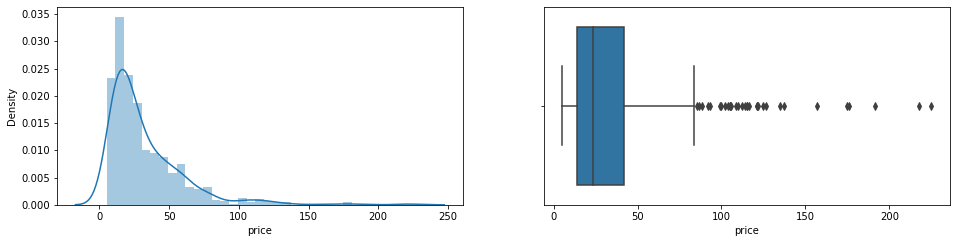

In [64]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,3)
sns.distplot(table_analyse['price'])
plt.subplot(2,2,4)
sns.boxplot(table_analyse['price'])
plt.show()

Dans un 1er temps, les représentations graphiques de la distribution des prix nous permet déjà d'identifier que la variable  contient des outliers

#### 2.2.a Trouver les outliers à l'aide de l'écart interquartile (IQR)

Dans les statistiques descriptives, l'écart interquartile (IQR) est une mesure de dispersion statistique, étant égal à la différence entre le troisième quartile (Q3) et le premier quartile (Q1), c'est-à-dire, IQR = Q3 - Q1.

On dit qu'une valeur est aberrante dans une distribution si elle est  plus d'une fois et demie la longueur de la boîte à l'écart du quartile inférieur ou supérieur. Autrement dit, si un nombre est inférieur à Q1 - 1,5 × IQR ou supérieur à Q3 + 1,5 × IQR, alors c'est une valeur aberrante.

In [65]:
# D'abord on calcule les quartiles pour déterminer l'IQR

Q1 = table_analyse['price'].quantile(0.25)
Q2 = table_analyse['price'].quantile(0.50)
Q3 = table_analyse['price'].quantile(0.75)

IQR = Q3 - Q1 
print("L'écart interquartile =", IQR)

L'écart interquartile = 28.075000000000003


In [66]:
# On calcule ensuite les limites inférieure et supérieure

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

print('La limite inférieure est', lower_limit)
print('La limite supérieure est', upper_limit)

La limite inférieure est -28.012500000000003
La limite supérieure est 84.28750000000001


Nos outliers seront donc tous les prix > 84.3 . Nous n'avons pas besoin de prendre en compte la limite inférieure car un prix ne peut être négatif.

In [67]:
# Pour afficher les outliers

outliers_IQR = table_analyse[(table_analyse['price'] > 84.3)]
outliers_IQR

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,...,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,CA_produit
64,15382,0.0,taxable,2.0,2018-02-13 11:08:45,2018-02-13 10:08:45,Zind-Humbrecht Riesling Grand Cru Rangen De Th...,"Le nez est puissant, dominant, riche, sur la f...",zind-humbrecht-riesling-gc-rangen-thann-clos-s...,2020-02-08 11:45:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4115,1,100.0,11,instock,15382,both,0.0
66,11668,0.0,taxable,2.0,2018-02-13 11:43:55,2018-02-13 10:43:55,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,Le nez dévoile déjà une belle intensité de fru...,zind-humbrecht-pinot-gris-grand-cru-rangen-de-...,2020-02-20 09:55:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4132,1,88.4,5,instock,11668,both,0.0
200,15940,5.0,taxable,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,Issu d’un assemblage de 70% de Pinot Noir du g...,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,...,https://www.bottle-neck.fr/?post_type=product&...,product,4352,1,225.0,0,outofstock,15940,both,1125.0
202,12589,11.0,taxable,2.0,2018-03-02 10:46:10,2018-03-02 09:46:10,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,Le Blanc de Noirs représente le meilleur du sa...,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,2020-08-13 10:15:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4355,1,126.5,2,instock,12589,both,1391.5
206,13853,1.0,taxable,2.0,2018-03-02 11:11:48,2018-03-02 10:11:48,Champagne Larmandier-Bernier Grand Cru Les Che...,Belle maîtrise de ce millésime compliqué en Ch...,champagne-larmandier-bernier-grand-cru-vieille...,2019-12-23 09:30:11,...,https://www.bottle-neck.fr/?post_type=product&...,product,4359,1,85.6,0,outofstock,13853,both,85.6
219,3510,13.0,taxable,2.0,2018-03-22 11:21:05,2018-03-22 10:21:05,Cognac Frapin VIP XO,La cuvée VIP XO à été enrichie d’eaux-de-vie t...,cognac-frapin-vip-xo,2020-08-22 11:35:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,4402,1,176.0,8,instock,3510,both,2288.0
220,3507,2.0,taxable,2.0,2018-03-22 11:32:55,2018-03-22 10:32:55,Cognac Frapin Château de Fontpinot XO,"Exclusivement vendangé, distillé, vieilli et m...",cognac-frapin-fontpinot-xo,2020-08-12 09:30:16,...,https://www.bottle-neck.fr/?post_type=product&...,product,4404,1,108.5,2,instock,3507,both,217.0
222,7819,0.0,taxable,2.0,2018-03-22 11:42:48,2018-03-22 10:42:48,Cognac Frapin Château de Fontpinot 1989 20 Ans...,Eau-de-Vie distillée à partir de raisins de Gr...,cognac-frapin-chateau-de-fontpinot-1989-20-ans,2020-03-14 16:05:04,...,https://www.bottle-neck.fr/?post_type=product&...,product,4406,1,157.0,3,instock,7819,both,0.0
223,3509,1.0,taxable,2.0,2018-03-22 11:49:53,2018-03-22 10:49:53,Cognac Frapin Cigar Blend,Ce cognac bénéficie d'un vieillissement plus l...,cognac-frapin-cigar-blend,2020-07-04 09:45:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,4407,1,104.0,6,instock,3509,both,104.0
228,12857,0.0,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4582,1,109.6,7,instock,12857,both,0.0


In [68]:
# Pour compter le nombre d'outliers :

outliers_IQR["price"].count()

32

In [69]:
list(outliers_IQR["price"])

[100.0,
 88.4,
 225.0,
 126.5,
 85.6,
 176.0,
 108.5,
 157.0,
 104.0,
 109.6,
 102.3,
 137.0,
 217.5,
 105.0,
 105.0,
 112.0,
 86.8,
 92.0,
 124.8,
 175.0,
 191.3,
 93.0,
 122.0,
 114.0,
 135.0,
 105.6,
 116.4,
 115.0,
 121.0,
 99.0,
 115.0,
 121.0]

Si l'on souhaite se débarasser des outliers et regarder de nouveau la distribution des prix :

In [70]:
new_analyse = table_analyse[table_analyse['price'] < upper_limit]
new_analyse.shape

(682, 21)

La fonction .shape nous permet de constater qu'on a bien supprimé  les 32 outliers

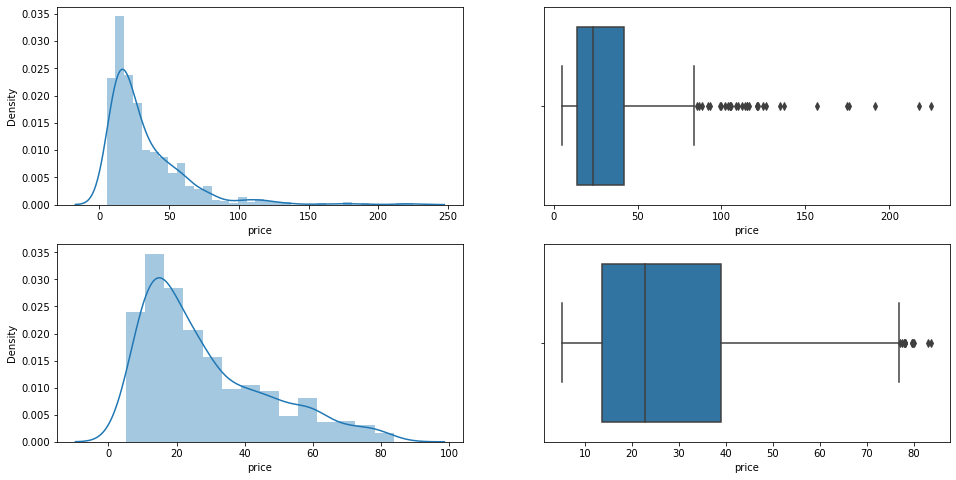

In [71]:
# Pour comparer avant/après

plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
sns.distplot(table_analyse['price'])
plt.subplot(2,2,2)
sns.boxplot(table_analyse['price'])

plt.subplot(2,2,3)
sns.distplot(new_analyse['price'])
plt.subplot(2,2,4)
sns.boxplot(new_analyse['price'])
plt.show()

La représentation graphique nous permet de constater qu'une fois le "correctif" appliquée, la distribution est bien plus linéaire même s'il existe toujours des outliers.

#### 2.2.b Trouver les outliers avec le Z-score

Ce score permet de comprendre si une valeur de données est supérieure ou inférieure à la moyenne et à quel point elle s'en éloigne. Plus précisément, le score Z indiquede combien d'écarts types un point de données est éloigné de la moyenne. Ils nous permettra donc d'identifier les outliers par rapport à la moyenne.

Il se calcule de la manière suivante : Z score = (x -mean) / std. deviation
- mean correspond à la moyenne des prix
- std.deviation est l'écart type empirique : il s'agit d'une mesure de la quantité de variation ou de dispersion d'un ensemble de valeurs. Un faible écart-type indique que les valeurs ont tendance à être proches de la moyenne de l'ensemble, tandis qu'un écart-type élevé indique que les valeurs sont réparties sur une plus grande plage.

In [72]:
# Calcul de la moyenne et de l'écart-type

mean = np.mean(table_analyse["price"])
std = np.std(table_analyse["price"])
print('La moyenne des prix est', mean)
print("L'écart type est", std)

La moyenne des prix est 32.49313725490197
L'écart type est 27.791042941002935


In [73]:
# seuil = 3

mean + 3 * std

115.86626607791078

Le score Z est essentiellement le nombre d'écarts types entre ma valeur réelle et la valeur moyenne. En fonction du contexte, on peut définir la valeur seuil du Z score pour classer une valeur comme aberrante ou non. ici, l'on considèrera que toutes les valeurs > 115.9 sont des outliers. On constate  qu'avec cette méthode, la valeur seuil obtenue est bien supérieure que lors que nous avons utilisé l'IQR précédemment (84.3). Cela s'explique par le choix d'un seuil = 3. Si l'on fixe le seuil = 2, le Z-score obtenu sera bien plus proche de la valeur IQR.

In [74]:
# seuil = 2

mean + 2 * std

88.07522313690784

In [75]:
# Pour afficher les outliers avec seuil = 3

outliers_z = table_analyse[(table_analyse['price'] > 115.9)]
print("Il y a", outliers_z["price"].count(),"outliers si l'on prend un seuil de 3")
outliers_z

Il y a 14 outliers si l'on prend un seuil de 3


,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,...,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,CA_produit
200,15940,5.0,taxable,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,Issu d’un assemblage de 70% de Pinot Noir du g...,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,...,https://www.bottle-neck.fr/?post_type=product&...,product,4352,1,225.0,0,outofstock,15940,both,1125.0
202,12589,11.0,taxable,2.0,2018-03-02 10:46:10,2018-03-02 09:46:10,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,Le Blanc de Noirs représente le meilleur du sa...,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,2020-08-13 10:15:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4355,1,126.5,2,instock,12589,both,1391.5
219,3510,13.0,taxable,2.0,2018-03-22 11:21:05,2018-03-22 10:21:05,Cognac Frapin VIP XO,La cuvée VIP XO à été enrichie d’eaux-de-vie t...,cognac-frapin-vip-xo,2020-08-22 11:35:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,4402,1,176.0,8,instock,3510,both,2288.0
222,7819,0.0,taxable,2.0,2018-03-22 11:42:48,2018-03-22 10:42:48,Cognac Frapin Château de Fontpinot 1989 20 Ans...,Eau-de-Vie distillée à partir de raisins de Gr...,cognac-frapin-chateau-de-fontpinot-1989-20-ans,2020-03-14 16:05:04,...,https://www.bottle-neck.fr/?post_type=product&...,product,4406,1,157.0,3,instock,7819,both,0.0
382,14220,5.0,taxable,2.0,2018-05-15 10:23:41,2018-05-15 08:23:41,Domaine Des Croix Corton Charlemagne Grand Cru...,"Ce Corton Charlemagne éblouit par son assise, ...",domaine-des-croix-corton-charlemagne-grand-cru...,2020-05-19 17:15:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4904,1,137.0,13,instock,14220,both,685.0
426,14581,0.0,taxable,2.0,2018-07-17 09:45:39,2018-07-17 07:45:39,David Duband Charmes-Chambertin Grand Cru 2014,Robe cerise chatoyante. Un nez de fruits rouge...,david-duband-charmes-chambertin-grand-cru-2014,2020-05-16 09:00:05,...,https://www.bottle-neck.fr/?post_type=product&...,product,5001,1,217.5,20,instock,14581,both,0.0
511,14915,0.0,taxable,2.0,2019-01-15 15:30:49,2019-01-15 14:30:49,Domaine Weinbach Gewurztraminer Grand Cru Furs...,"Né sur un sol marno-gréseux, ce Furstentum est...",domaine-weinbach-gewurztraminer-gc-furstentum-...,2019-01-23 09:33:57,...,https://www.bottle-neck.fr/?post_type=product&...,product,5612,1,124.8,12,instock,14915,both,0.0
553,15185,0.0,taxable,2.0,2019-03-13 14:43:22,2019-03-13 13:43:22,Camille Giroud Clos de Vougeot 2016,<div>Ce vin provient de vignes âgées de 50 ans...,camille-giroud-clos-de-vougeot-2016,2020-06-11 15:25:04,...,https://www.bottle-neck.fr/?post_type=product&...,product,5767,1,175.0,12,instock,15185,both,0.0
587,14983,3.0,taxable,2.0,2019-03-28 10:21:36,2019-03-28 09:21:36,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,Cet Ambonnay évoque les grands Pinots Noirs de...,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,2020-04-01 09:30:09,...,https://www.bottle-neck.fr/?post_type=product&...,product,5892,1,191.3,10,instock,14983,both,573.9
603,14775,0.0,taxable,2.0,2019-04-04 16:49:37,2019-04-04 14:49:37,Wemyss Malts Single Cask Scotch Whisky Choc 'n...,"710 bouteilles, 17 ans d'âge.\n\n<span title=""...",wemyss-malts-single-cask-scotch-whisky-choc-n-...,2020-03-11 09:30:09,...,https://www.bottle-neck.fr/?post_type=product&...,product,5917,1,122.0,4,instock,14775,both,0.0


In [76]:
# Pour afficher les outliers avec un seuil = 2

outliers_z2 = table_analyse[(table_analyse['price'] > 88)]
print("Il y a", outliers_z2["price"].count(),"outliers si l'on prend un seuil de 2")
outliers_z2

Il y a 30 outliers si l'on prend un seuil de 2


,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,...,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,CA_produit
64,15382,0.0,taxable,2.0,2018-02-13 11:08:45,2018-02-13 10:08:45,Zind-Humbrecht Riesling Grand Cru Rangen De Th...,"Le nez est puissant, dominant, riche, sur la f...",zind-humbrecht-riesling-gc-rangen-thann-clos-s...,2020-02-08 11:45:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4115,1,100.0,11,instock,15382,both,0.0
66,11668,0.0,taxable,2.0,2018-02-13 11:43:55,2018-02-13 10:43:55,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,Le nez dévoile déjà une belle intensité de fru...,zind-humbrecht-pinot-gris-grand-cru-rangen-de-...,2020-02-20 09:55:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4132,1,88.4,5,instock,11668,both,0.0
200,15940,5.0,taxable,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,Issu d’un assemblage de 70% de Pinot Noir du g...,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,...,https://www.bottle-neck.fr/?post_type=product&...,product,4352,1,225.0,0,outofstock,15940,both,1125.0
202,12589,11.0,taxable,2.0,2018-03-02 10:46:10,2018-03-02 09:46:10,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,Le Blanc de Noirs représente le meilleur du sa...,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,2020-08-13 10:15:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4355,1,126.5,2,instock,12589,both,1391.5
219,3510,13.0,taxable,2.0,2018-03-22 11:21:05,2018-03-22 10:21:05,Cognac Frapin VIP XO,La cuvée VIP XO à été enrichie d’eaux-de-vie t...,cognac-frapin-vip-xo,2020-08-22 11:35:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,4402,1,176.0,8,instock,3510,both,2288.0
220,3507,2.0,taxable,2.0,2018-03-22 11:32:55,2018-03-22 10:32:55,Cognac Frapin Château de Fontpinot XO,"Exclusivement vendangé, distillé, vieilli et m...",cognac-frapin-fontpinot-xo,2020-08-12 09:30:16,...,https://www.bottle-neck.fr/?post_type=product&...,product,4404,1,108.5,2,instock,3507,both,217.0
222,7819,0.0,taxable,2.0,2018-03-22 11:42:48,2018-03-22 10:42:48,Cognac Frapin Château de Fontpinot 1989 20 Ans...,Eau-de-Vie distillée à partir de raisins de Gr...,cognac-frapin-chateau-de-fontpinot-1989-20-ans,2020-03-14 16:05:04,...,https://www.bottle-neck.fr/?post_type=product&...,product,4406,1,157.0,3,instock,7819,both,0.0
223,3509,1.0,taxable,2.0,2018-03-22 11:49:53,2018-03-22 10:49:53,Cognac Frapin Cigar Blend,Ce cognac bénéficie d'un vieillissement plus l...,cognac-frapin-cigar-blend,2020-07-04 09:45:03,...,https://www.bottle-neck.fr/?post_type=product&...,product,4407,1,104.0,6,instock,3509,both,104.0
228,12857,0.0,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,...,https://www.bottle-neck.fr/?post_type=product&...,product,4582,1,109.6,7,instock,12857,both,0.0
381,14805,0.0,taxable,2.0,2018-05-15 10:10:57,2018-05-15 08:10:57,Domaine Des Croix Corton Grand Cru Les Grèves ...,Ce vin exhale de beaux arômes de fruits rouges...,domaine-des-croix-corton-grand-cru-les-greves-...,2020-06-27 09:00:07,...,https://www.bottle-neck.fr/?post_type=product&...,product,4903,1,102.3,20,instock,14805,both,0.0
